In [180]:
import os

from google.colab import drive
drive.mount('/content/gdrive')

os.chdir('/content/gdrive/MyDrive/first_try_of_fastai')

print("------------------------------------------------------------------")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
------------------------------------------------------------------


In [181]:
#export
import os
os.chdir('/content/gdrive/MyDrive/first_try_of_fastai/exp')
from nb_07a import *
os.chdir('/content/gdrive/MyDrive/first_try_of_fastai')

In [182]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [183]:
path = datasets.untar_data(datasets.URLs.IMAGENETTE_160)
path

PosixPath('/root/.fastai/data/imagenette2-160')

In [184]:
#export
import PIL,os,mimetypes
Path.ls = lambda x: list(x.iterdir())

In [185]:
path.ls()

[PosixPath('/root/.fastai/data/imagenette2-160/.DS_Store'),
 PosixPath('/root/.fastai/data/imagenette2-160/val'),
 PosixPath('/root/.fastai/data/imagenette2-160/train'),
 PosixPath('/root/.fastai/data/imagenette2-160/noisy_imagenette.csv')]

In [186]:
(path/'val').ls

<bound method <lambda> of PosixPath('/root/.fastai/data/imagenette2-160/val')>

In [187]:
path_tench = path/'val'/'n01440764'

In [188]:
img_fn = path_tench.ls()[0]
img_fn

PosixPath('/root/.fastai/data/imagenette2-160/val/n01440764/n01440764_6301.JPEG')

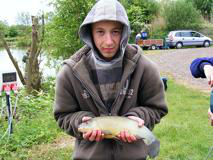

In [189]:
img = PIL.Image.open(img_fn)
img

In [190]:
import numpy
imga = numpy.array(img)

In [191]:
imga.shape

(160, 213, 3)

In [192]:
imga[:10,:10,0]

array([[251, 251, 251, 251, ..., 251, 251, 251, 251],
       [251, 251, 251, 251, ..., 251, 251, 251, 251],
       [251, 251, 251, 251, ..., 251, 251, 251, 251],
       [251, 251, 251, 251, ..., 251, 251, 251, 251],
       ...,
       [251, 251, 251, 251, ..., 251, 251, 251, 251],
       [251, 251, 251, 251, ..., 251, 251, 251, 251],
       [251, 251, 251, 251, ..., 251, 251, 251, 251],
       [251, 251, 251, 251, ..., 251, 251, 251, 251]], dtype=uint8)

In [193]:
#export
image_extensions = set(k for k,v in mimetypes.types_map.items() if v.startswith('image/') )

In [194]:
''.join(image_extensions)

'.crw.pnm.pcx.ppm.ras.djvu.jpe.xwd.psd.bmp.png.jpg.jng.tiff.svgz.jpm.pgm.tif.jp2.jpx.cpt.ief.jpeg.ico.cdt.xbm.art.orf.pat.erf.jpg2.svg.wbmp.pbm.nef.cr2.jpf.gif.djv.cdr.rgb.xpm'

In [195]:
#export
def setify(o): return o if isinstance(o,set) else set(listify(o))

In [196]:
#test_eq(setify('aa'), {'aa'})
#test_eq(setify(['aa',1]), {'aa',1})
#test_eq(setify(None), set())
#test_eq(setify(1), {1})
#test_eq(setify({1}), {1})

In [197]:
#export
def _get_files(p, fs, extensions=None):
  p = Path(p)
  res = [p/f for f in fs if not f.startswith('.')
          and ((not extensions) or f'.{f.split(".")[-1].lower()}' in  extensions)]
  return res

In [198]:
t = [o.name for o in os.scandir(path_tench)]
t = _get_files(path, t, extensions=image_extensions)
t[:3]

[PosixPath('/root/.fastai/data/imagenette2-160/n01440764_6301.JPEG'),
 PosixPath('/root/.fastai/data/imagenette2-160/n01440764_490.JPEG'),
 PosixPath('/root/.fastai/data/imagenette2-160/n01440764_27422.JPEG')]

In [199]:
#export
def get_files(path, extensions=None, recurse=False, include=None):
  path = Path(path)
  extensions = setify(extensions)
  extensions = {e.lower() for e in extensions}
  if recurse:
    res = []
    for p,d,f in os.walk(path):
      if include is not None: d[:] = [o for o in d if o in include]
      else:                   d[:] = [o for o in d if not o.startswith('.')]
      res += _get_files(p,f,extensions)
    return res
  else:
    f = [o.name for o in os.scandir(path) if o.is_file()]
    return _get_files(path, f, extensions)

In [200]:
get_files(path_tench, image_extensions)[:5]

[PosixPath('/root/.fastai/data/imagenette2-160/val/n01440764/n01440764_6301.JPEG'),
 PosixPath('/root/.fastai/data/imagenette2-160/val/n01440764/n01440764_490.JPEG'),
 PosixPath('/root/.fastai/data/imagenette2-160/val/n01440764/n01440764_27422.JPEG'),
 PosixPath('/root/.fastai/data/imagenette2-160/val/n01440764/n01440764_10120.JPEG'),
 PosixPath('/root/.fastai/data/imagenette2-160/val/n01440764/n01440764_2920.JPEG')]

In [201]:
get_files(path, image_extensions, recurse=True)[:3]

[PosixPath('/root/.fastai/data/imagenette2-160/val/n02979186/n02979186_491.JPEG'),
 PosixPath('/root/.fastai/data/imagenette2-160/val/n02979186/n02979186_9811.JPEG'),
 PosixPath('/root/.fastai/data/imagenette2-160/val/n02979186/n02979186_21472.JPEG')]

In [202]:
all_fns = get_files(path, image_extensions, recurse=True)
len(all_fns)

13394

In [203]:
%timeit -n 10 get_files(path, image_extensions, recurse=True)

10 loops, best of 5: 79.6 ms per loop


**Prepare the model**

In [204]:
#export
def compose(x, funcs, *args, order_key="_order", **kwargs):
  key = lambda o: getattr(o, order_key, 0)
  for f in sorted(listify(funcs), key=key): x = f(x, **kwargs)
  return x

class ItemList(ListContainer):
  def __init__(self, items, path='.', tfms=None):
    super().__init__(items)
    self.path, self.tfms = Path(path), tfms

  def __repr__(self): return f'{super().__repr__()}\nPath: {self.path}'
  def new(self, items): return self.__class__(items, self.path, tfms = self.tfms)

  def get(self, i): return i
  def _get(self, i): return compose(self.get(i), self.tfms)

  def __getitem__(self, idx):
    res = super().__getitem__(idx)
    if isinstance(res, list): return [self._get(o) for o in res]
    return self._get(res)

class ImageList(ItemList):
  @classmethod
  def from_files(cls, path, extensions = None, recurse=True, include=None, **kwargs):
    if extensions is None: extensions = image_extensions
    return cls(get_files(path, extensions, recurse=recurse, include = include), path, **kwargs)

  def get(self, fn): return PIL.Image.open(fn)

In [205]:
#export
class Transform(): _order=0

class MakeRGB(Transform):
  def __call__(self, item): return item.convert('RGB')

def make_rgb(item): return item.convert('RGB')

In [206]:
il = ImageList.from_files(path, tfms=make_rgb)

In [207]:
il


ImageList (13394 items)
[PosixPath('/root/.fastai/data/imagenette2-160/val/n02979186/n02979186_491.JPEG'), PosixPath('/root/.fastai/data/imagenette2-160/val/n02979186/n02979186_9811.JPEG'), PosixPath('/root/.fastai/data/imagenette2-160/val/n02979186/n02979186_21472.JPEG'), PosixPath('/root/.fastai/data/imagenette2-160/val/n02979186/n02979186_13661.JPEG'), PosixPath('/root/.fastai/data/imagenette2-160/val/n02979186/n02979186_8211.JPEG'), PosixPath('/root/.fastai/data/imagenette2-160/val/n02979186/n02979186_1870.JPEG'), PosixPath('/root/.fastai/data/imagenette2-160/val/n02979186/n02979186_9910.JPEG'), PosixPath('/root/.fastai/data/imagenette2-160/val/n02979186/n02979186_2772.JPEG'), PosixPath('/root/.fastai/data/imagenette2-160/val/n02979186/n02979186_23730.JPEG'), PosixPath('/root/.fastai/data/imagenette2-160/val/n02979186/n02979186_9790.JPEG'), ...]
Path: /root/.fastai/data/imagenette2-160

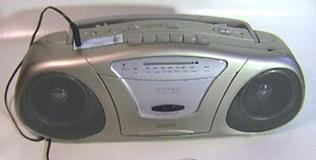

In [208]:
img = il[0];img

**split validation set**

In [209]:
fn = il.items[0];fn

PosixPath('/root/.fastai/data/imagenette2-160/val/n02979186/n02979186_491.JPEG')

In [210]:
fn.parent.parent.name

'val'

In [211]:
#export
def grandparent_splitter(fn, valid_name = 'valid', train_name="train"):
  gp = fn.parent.parent.name
  return True if gp==valid_name else False if gp==train_name else None

def split_by_func(ds, f):
  items = ds.items
  mask = [f(o) for o in items]

  train = [o for o,m in zip(items, mask) if m==False]
  valid = [o for o,m in zip(items, mask) if m==True]
  return train, valid

In [212]:
splitter = partial(grandparent_splitter, valid_name='val')

In [213]:
%time train, valid = split_by_func(il, splitter)

CPU times: user 42.3 ms, sys: 0 ns, total: 42.3 ms
Wall time: 42.6 ms


In [214]:
len(train), len(valid)

(9469, 3925)

In [215]:
#export
class SplitData():
  def __init__(self, train, valid): self.train, self.valid = train, valid

  def __getattr__(self,k): return getattr(self.train,k)

  @classmethod
  def split_by_func(cls, il, f):
    lists = map(il.new, split_by_func(il, f))
    return cls(*lists)

  def __repr__(self): return f'{self.__class__.__name__}\nTrain: {self.train}\nValid: {self.valid}\n'

In [216]:
sd = SplitData.split_by_func(il, splitter)
sd

SplitData
Train: ImageList (9469 items)
[PosixPath('/root/.fastai/data/imagenette2-160/train/n02979186/n02979186_1397.JPEG'), PosixPath('/root/.fastai/data/imagenette2-160/train/n02979186/n02979186_14958.JPEG'), PosixPath('/root/.fastai/data/imagenette2-160/train/n02979186/n02979186_10747.JPEG'), PosixPath('/root/.fastai/data/imagenette2-160/train/n02979186/n02979186_14428.JPEG'), PosixPath('/root/.fastai/data/imagenette2-160/train/n02979186/n02979186_3656.JPEG'), PosixPath('/root/.fastai/data/imagenette2-160/train/n02979186/n02979186_12137.JPEG'), PosixPath('/root/.fastai/data/imagenette2-160/train/n02979186/n02979186_437.JPEG'), PosixPath('/root/.fastai/data/imagenette2-160/train/n02979186/n02979186_24275.JPEG'), PosixPath('/root/.fastai/data/imagenette2-160/train/n02979186/n02979186_10713.JPEG'), PosixPath('/root/.fastai/data/imagenette2-160/train/n02979186/ILSVRC2012_val_00002034.JPEG'), ...]
Path: /root/.fastai/data/imagenette2-160
Valid: ImageList (3925 items)
[PosixPath('/root/.

**Labelling**

In [217]:
#export
from collections import OrderedDict

def uniqueify(x, sort = False):
  res = list(OrderedDict.fromkeys(x).keys())
  if sort: res.sort()
  return res

In [223]:
#export
class Processor():
  def process(self, items): return items

class CategoryProcessor(Processor):
  def __init__(self): self.vocab=None

  def process(self, items):
    if self.vocab is None:
      self.vocab = uniqueify(items)
      self.otoi = {v:k for k,v in enumerate(self.vocab)}
    return [self.proc1(o) for o in items]

  def proc1(self, item): return self.otoi[item]

  def deprocess(self, idxs):
    assert self.vocab is not None
    return [self.deproc1(idx) for idx in idxs]

  def deproc1(self, idx): return self.vocab[idx]

class ProcessedItemList(ListContainer):
  def __init__(self, inputs, processor):
    self.processor = processor
    items = processor.process(inputs)
    super().__init__(items)

  def obj(self, idx):
    res = self[idx]
    if isinstance(res, (tuple, list, Generator)): return self.processor.deprocess(res)
    return self.processor.deproc1(idx)

In [224]:
#export
def parent_labeler(fn): return fn.parent.name

def _label_by_func(ds, f): return [f(o) for o in ds.items]

class LabeledData():
  def __init__(self, x ,y): self.x, self.y = x,y

  def __repr__(self): return f'{self.__class__.__name__}\nx: {self.x}\ny:{self.y}\n'
  def __getitem__(self, idx): return self.x[idx], self.y[idx]

  @classmethod
  def _label_by_func(cls, il, f, proc=None):
    labels = _label_by_func(il, f)
    proc_labels = ProcessedItemList(labels, proc)
    return cls(il, proc_labels)

def label_by_func(sd, f):
  proc = CategoryProcessor()
  train = LabeledData._label_by_func(sd.train, f, proc)
  valid = LabeledData._label_by_func(sd.valid, f, proc)
  return SplitData(train, valid)

In [225]:
ll = label_by_func(sd, parent_labeler)

In [226]:
assert ll.train.y.processor is ll.valid.y.processor

In [227]:
ll.train.y.items[0], ll.train.y.obj(0), ll.train.y.obj(slice(2))

(0, 'n02979186', ['n02979186', 'n02979186'])

In [229]:
ll

SplitData
Train: LabeledData
x: ImageList (9469 items)
[PosixPath('/root/.fastai/data/imagenette2-160/train/n02979186/n02979186_1397.JPEG'), PosixPath('/root/.fastai/data/imagenette2-160/train/n02979186/n02979186_14958.JPEG'), PosixPath('/root/.fastai/data/imagenette2-160/train/n02979186/n02979186_10747.JPEG'), PosixPath('/root/.fastai/data/imagenette2-160/train/n02979186/n02979186_14428.JPEG'), PosixPath('/root/.fastai/data/imagenette2-160/train/n02979186/n02979186_3656.JPEG'), PosixPath('/root/.fastai/data/imagenette2-160/train/n02979186/n02979186_12137.JPEG'), PosixPath('/root/.fastai/data/imagenette2-160/train/n02979186/n02979186_437.JPEG'), PosixPath('/root/.fastai/data/imagenette2-160/train/n02979186/n02979186_24275.JPEG'), PosixPath('/root/.fastai/data/imagenette2-160/train/n02979186/n02979186_10713.JPEG'), PosixPath('/root/.fastai/data/imagenette2-160/train/n02979186/ILSVRC2012_val_00002034.JPEG'), ...]
Path: /root/.fastai/data/imagenette2-160
y:ProcessedItemList (9469 items)
[